In [1]:
# import duckdb
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def db_create(sf):
    con = duckdb.connect(f'database_{sf}.duckdb')

    ### creating tables

    con.execute("""
    CREATE TABLE customer
    (
        C_CUSTKEY       INTEGER,
        C_NAME          VARCHAR,
        C_ADDRESS       VARCHAR,
        C_CITY          VARCHAR,
        C_NATION        VARCHAR,
        C_REGION        VARCHAR,
        C_PHONE         VARCHAR,
        C_MKTSEGMENT    VARCHAR
    )
    """)

    con.execute("""
    CREATE TABLE lineorder
    (
        LO_ORDERKEY             INTEGER,
        LO_LINENUMBER           INTEGER,
        LO_CUSTKEY              INTEGER,
        LO_PARTKEY              INTEGER,
        LO_SUPPKEY              INTEGER,
        LO_ORDERDATE            VARCHAR,
        LO_ORDERPRIORITY        VARCHAR,
        LO_SHIPPRIORITY         INTEGER,
        LO_QUANTITY             INTEGER,
        LO_EXTENDEDPRICE        INTEGER,
        LO_ORDTOTALPRICE        INTEGER,
        LO_DISCOUNT             INTEGER,
        LO_REVENUE              INTEGER,
        LO_SUPPLYCOST           INTEGER,
        LO_TAX                  INTEGER,
        LO_COMMITDATE           VARCHAR,
        LO_SHIPMODE             VARCHAR
    )
    """)

    con.execute("""
    CREATE TABLE part
    (
            P_PARTKEY       INTEGER,
            P_NAME          VARCHAR,
            P_MFGR          VARCHAR,
            P_CATEGORY      VARCHAR,
            P_BRAND         VARCHAR,
            P_COLOR         VARCHAR,
            P_TYPE          VARCHAR,
            P_SIZE          INTEGER,
            P_CONTAINER     VARCHAR
    )
    """)

    con.execute("""
    CREATE TABLE supplier
    (
            S_SUPPKEY       INTEGER,
            S_NAME          VARCHAR,
            S_ADDRESS       VARCHAR,
            S_CITY          VARCHAR,
            S_NATION        VARCHAR,
            S_REGION        VARCHAR,
            S_PHONE         VARCHAR
    )
    """)

    con.execute("""
    CREATE TABLE date
    (
            D_DATEKEY            VARCHAR,
            D_DATE               VARCHAR,
            D_DAYOFWEEK          VARCHAR,
            D_MONTH              VARCHAR,
            D_YEAR               INTEGER,
            D_YEARMONTHNUM       INTEGER,
            D_YEARMONTH          VARCHAR,
            D_DAYNUMINWEEK       INTEGER,
            D_DAYNUMINMONTH      INTEGER,
            D_DAYNUMINYEAR       INTEGER,
            D_MONTHNUMINYEAR     INTEGER,
            D_WEEKNUMINYEAR      INTEGER,
            D_SELLINGSEASON      VARCHAR,
            D_LASTDAYINWEEKFL    INTEGER,
            D_LASTDAYINMONTHFL   INTEGER,
            D_HOLIDAYFL          INTEGER,
            D_WEEKDAYFL          INTEGER
    )
    """)
    con.close()

In [ ]:
# db_create(1)

In [ ]:
# db_create(10)

In [ ]:
# db_create(50)

In [ ]:
def data_import(data_path, sf):
    con = duckdb.connect(f'database_{sf}.duckdb')
    
    try:
        con.execute(f"COPY customer FROM '{data_path}/customer.tbl' (HEADER);")
    except Exception as e:
        print(f"Error importing customer data: {e}")
    
    try:
        con.execute(f"COPY lineorder FROM '{data_path}/lineorder.tbl' (HEADER);")
    except Exception as e:
        print(f"Error importing lineorder data: {e}")
    
    try:
        con.execute(f"COPY part FROM '{data_path}/part.tbl' (HEADER);")
    except Exception as e:
        print(f"Error importing part data: {e}")
    
    try:
        con.execute(f"COPY supplier FROM '{data_path}/supplier.tbl' (HEADER);")
    except Exception as e:
        print(f"Error importing supplier data: {e}")
    
    try:
        con.execute(f"COPY date FROM '{data_path}/date.tbl' (HEADER);")
    except Exception as e:
        print(f"Error importing date data: {e}")
    
    con.close()


In [ ]:
# data_import('data/sf_1',1)

In [ ]:
# data_import('data/sf_10',10)

In [ ]:
# data_import('data/sf_50',50)

In [ ]:
def query_run(sf, thread_count, folder,run_no):
    # Ensure the folder exists
    profiling_folder = f'results/tc_{thread_count}/{folder}'
    os.makedirs(profiling_folder, exist_ok=True)

    # Connect to the DuckDB database
    con = duckdb.connect(f'database_{sf}.duckdb')

    # Set PRAGMA settings for thread count
    con.execute(f"PRAGMA threads={thread_count};")

    # Define the queries to run
    queries = [
    "SELECT sum(LO_EXTENDEDPRICE * LO_DISCOUNT) AS REVENUE FROM lineorder, date WHERE LO_ORDERDATE = D_DATEKEY AND D_YEAR = 1993 AND LO_DISCOUNT BETWEEN 1 AND 3 AND LO_QUANTITY < 25;",
    "SELECT sum(LO_REVENUE), D_YEAR, P_BRAND FROM lineorder, date, part, supplier WHERE LO_ORDERDATE = D_DATEKEY AND LO_PARTKEY = P_PARTKEY AND LO_SUPPKEY = S_SUPPKEY AND P_CATEGORY = 'MFGR#12' AND S_REGION = 'AMERICA' GROUP BY D_YEAR, P_BRAND ORDER BY D_YEAR, P_BRAND;",
    "SELECT C_NATION, S_NATION, D_YEAR, sum(LO_REVENUE) AS REVENUE FROM customer, lineorder, supplier, date WHERE LO_CUSTKEY = C_CUSTKEY AND LO_SUPPKEY = S_SUPPKEY AND LO_ORDERDATE = D_DATEKEY AND C_REGION = 'ASIA' AND S_REGION = 'ASIA' AND D_YEAR >= 1992 AND D_YEAR <= 1997 GROUP BY C_NATION, S_NATION, D_YEAR ORDER BY D_YEAR ASC, REVENUE DESC;",
    "SELECT D_YEAR, C_NATION, sum(LO_REVENUE - LO_SUPPLYCOST) AS PROFIT FROM date, customer, supplier, part, lineorder WHERE LO_CUSTKEY = C_CUSTKEY AND LO_SUPPKEY = S_SUPPKEY AND LO_PARTKEY = P_PARTKEY AND LO_ORDERDATE = D_DATEKEY AND C_REGION = 'AMERICA' AND S_REGION = 'AMERICA' AND (P_MFGR = 'MFGR#1' OR P_MFGR = 'MFGR#2') GROUP BY D_YEAR, C_NATION ORDER BY D_YEAR, C_NATION;"
    ]

    # Run each query, generate query plans, and save profiling results
    for idx, query in enumerate(queries, start=1):
        profiling_output = f"{profiling_folder}/query_{idx}_profile_run_{run_no}.json"
        
        # Enable profiling in JSON format
        con.execute("PRAGMA enable_profiling='json';")
        con.execute(f"PRAGMA profiling_output='{profiling_output}';")

        # Execute the query
        con.execute(query)
        
        # Disable profiling after each query
        con.execute("PRAGMA disable_profiling;")
    
    # Close the database connection
    con.close()


In [ ]:
for i in range(1,11):
    query_run(1,1,'sf_1',i)
    query_run(1,4,'sf_1',i)
    query_run(1,8,'sf_1',i)

In [ ]:
for i in range(1,11):
    query_run(10,1,'sf_10',i)
    query_run(10,4,'sf_10',i)
    query_run(10,8,'sf_10',i)

In [ ]:
for i in range(1,11):
    query_run(50,1,'sf_50',i)
    query_run(50,4,'sf_50',i)
    query_run(50,8,'sf_50',i)

### Visualizations

In [2]:
def get_data(tc,sf):
    base_dir = f"results/{tc}/{sf}"  # Replace with the actual path

    # Initialize a list to store data
    data_list = []

    # Iterate through all files in the directory
    for file_name in sorted(os.listdir(base_dir)):
        if file_name.endswith(".json"):
            # Extract query and run number from the file name
            parts = file_name.split("_")
            query_number = int(parts[1])  # e.g., "1" in "query_1"
            run_number = int(parts[-1].split(".")[0])  # e.g., "0" in "run_0.json"

            # Load JSON data
            file_path = os.path.join(base_dir, file_name)
            with open(file_path, "r") as file:
                data = json.load(file)

            # Append data to the list
            data_list.append({
                "query": query_number,
                "run_number": run_number,
                "latency": data["latency"],
                "cpu_time": data["cpu_time"],
                "cumulative_rows_scanned": data['cumulative_rows_scanned']
            })

    # Create a Pandas DataFrame from the list
    df = pd.DataFrame(data_list)
    return df

In [3]:
df_8_1 = get_data('tc_8','sf_1')
df_4_1 = get_data('tc_4','sf_1')
df_1_1 = get_data('tc_1','sf_1')

In [4]:
df_8_1['Scaling Factor'] = 1
df_4_1['Scaling Factor'] = 1
df_1_1['Scaling Factor'] = 1

df_8_1['Threads'] = 8
df_4_1['Threads'] = 4
df_1_1['Threads'] = 1

In [5]:
df_8_50 = get_data('tc_8','sf_50')
df_4_50 = get_data('tc_4','sf_50')
df_1_50 = get_data('tc_1','sf_50')

In [6]:
df_8_50['Scaling Factor'] = 50
df_4_50['Scaling Factor'] = 50
df_1_50['Scaling Factor'] = 50

df_8_50['Threads'] = 8
df_4_50['Threads'] = 4
df_1_50['Threads'] = 1

In [7]:
df_8_10 = get_data('tc_8','sf_10')
df_4_10 = get_data('tc_4','sf_10')
df_1_10 = get_data('tc_1','sf_10')

In [8]:
df_8_10['Scaling Factor'] = 10
df_4_10['Scaling Factor'] = 10
df_1_10['Scaling Factor'] = 10

df_8_10['Threads'] = 8
df_4_10['Threads'] = 4
df_1_10['Threads'] = 1

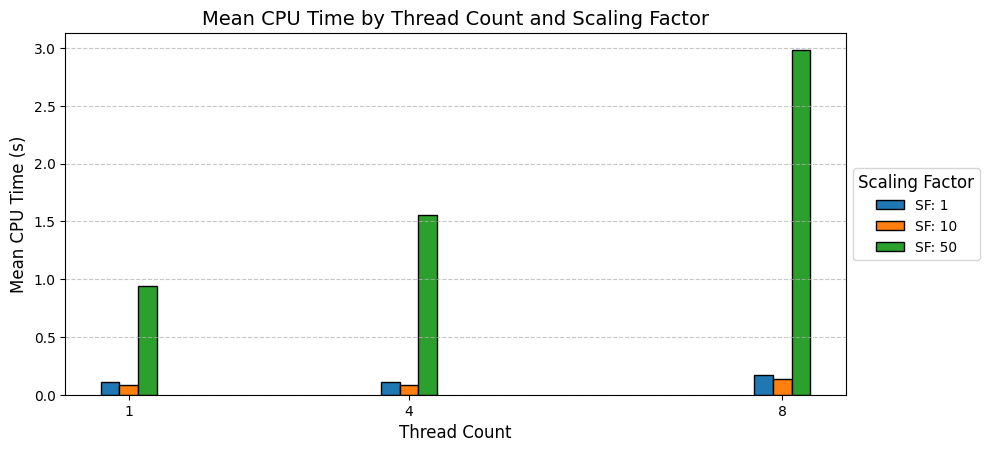

In [9]:
# Combine all dataframes
combined_df = pd.concat([
    df_1_1, df_4_1, df_8_1,
    df_1_10, df_4_10, df_8_10,
    df_1_50, df_4_50, df_8_50
])

# Group by scaling factor and thread count, then calculate the mean
mean_cpu_times = (
    combined_df
    .groupby(['Scaling Factor', 'Threads'])['cpu_time']
    .mean()
    .reset_index()
)

# Plotting parameters
plt.figure(figsize=(10, 5))
bar_width = 0.2
positions = [-bar_width, 0, bar_width]

# Generate bars for each scaling factor
scaling_factors = mean_cpu_times['Scaling Factor'].unique()
for i, sf in enumerate(scaling_factors):
    subset = mean_cpu_times[mean_cpu_times['Scaling Factor'] == sf]
    plt.bar(
        subset['Threads'] + positions[i],  # Adjust bar positions
        subset['cpu_time'],               # Heights of the bars
        width=bar_width,                  # Bar width
        label=f'SF: {sf}',                # Label with scaling factor
        edgecolor='black'                 # Bar edge color
    )

# Label axes and title
plt.xlabel('Thread Count', fontsize=12)
plt.ylabel('Mean CPU Time (s)', fontsize=12)
plt.title('Mean CPU Time by Thread Count and Scaling Factor', fontsize=14)

# Customize x-ticks
plt.xticks([1, 4, 8], ['1', '4', '8'], fontsize=10)

# Add legend outside and grid
plt.legend(title='Scaling Factor', fontsize=10, title_fontsize=12, loc='center left',bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout and show plot
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust space for the legend
plt.show()

In [10]:
mean_cpu_times

,Scaling Factor,Threads,cpu_time
0,1,1,0.108754
1,1,4,0.114036
2,1,8,0.170705
3,10,1,0.086129
4,10,4,0.082250
5,10,8,0.138243
6,50,1,0.942049
7,50,4,1.552847
8,50,8,2.980759


In [ ]:
# Combining all dataframes
combined_df = pd.concat([df_1_1, df_4_1, df_8_1,df_1_10, df_4_10, df_8_10, df_1_50, df_4_50, df_8_50])

# Grouping and calculating the mean
mean_latency = combined_df.groupby(['Scaling Factor', 'Threads'])['latency'].mean().reset_index()

plt.figure(figsize=(10, 5))
bar_width = 0.2
positions = [-bar_width, 0, bar_width]

for i, sf in enumerate(mean_latency['Scaling Factor'].unique()):
    subset = mean_latency[mean_latency['Scaling Factor'] == sf]
    plt.bar(
        subset['Threads'] + positions[i],
        subset['latency'],
        width=bar_width,
        label=sf,
        edgecolor = 'black'
    )

plt.xlabel('Thread Count')
plt.ylabel('Mean Latency (s)')
plt.title('Mean Latency by Thread Count and Scaling Factor')
plt.xticks([1, 4, 8], ['1', '4', '8'])
plt.legend(title='Scaling Factor', fontsize=10, title_fontsize=12, loc='center left',bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
datasets = {
    "TC 1 | SF 1": df_1_1,
    "TC 4 | SF 1": df_4_1,
    "TC 8 | SF 1": df_8_1,
    "TC 1 | SF 10": df_1_10,
    "TC 4 | SF 10": df_4_10,
    "TC 8 | SF 10": df_8_10,
    "TC 1 | SF 50": df_1_50,
    "TC 4 | SF 50": df_4_50,
    "TC 8 | SF 50": df_8_50,
}

In [ ]:
def plot_multiple_boxplots(dfs_dict, column, title, y):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid of subplots
        
    for (df_name, df), ax in zip(dfs_dict.items(), axes.flatten()):
        # Prepare data for boxplot
        data_to_plot = [df[df['query'] == query][column] for query in df['query'].unique()]
        query_labels = [f"Query {query}" for query in df['query'].unique()]
        
        # Plot on the current axis
        ax.boxplot(data_to_plot, tick_labels=query_labels, showmeans = True)
        ax.set_title(df_name)  # Use the variable name as the title for each subplot
        ax.set_ylabel(y)
        ax.grid(True)
    
    # Hide any unused subplots if dfs_dict has fewer than 9 datasets
    for ax in axes.flatten()[len(dfs_dict):]:
        ax.set_visible(False)
    
    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the super title
    plt.show()


In [ ]:
plot_multiple_boxplots(datasets,'cpu_time','CPU Time','CPU Time (s)')

In [ ]:
plot_multiple_boxplots(datasets,'latency','Latency','Latency Time (s)')

In [ ]:
plot_multiple_boxplots(datasets,'cumulative_rows_scanned','Cumulative Rows Scanned','Rows Scanned')

In [ ]:
df_1_1

In [ ]:
# Calculate percentage difference for each scaling factor group
mean_cpu_times['Percentage Difference'] = mean_cpu_times.groupby("Scaling Factor")["cpu_time"].transform(
    lambda x: x.pct_change() * 100
)

# Calculate percentage difference between scaling factors for the same thread count
mean_cpu_times['Percentage Difference Between Scaling Factors'] = mean_cpu_times.groupby("Threads")["cpu_time"].transform(
    lambda x: x.pct_change() * 100
)


In [ ]:
mean_cpu_times

In [ ]:
# Calculate percentage difference for each scaling factor group
mean_latency['Percentage Difference'] = mean_latency.groupby("Scaling Factor")["latency"].transform(
    lambda x: x.pct_change() * 100
)

# Calculate percentage difference between scaling factors for the same thread count
mean_latency['Percentage Difference Between Scaling Factors'] = mean_latency.groupby("Threads")["latency"].transform(
    lambda x: x.pct_change() * 100
)


In [ ]:
mean_latency